In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

100%|██████████| 26.4M/26.4M [00:01<00:00, 16.0MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 271kB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 5.02MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 10.5MB/s]
/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at /pytorch/aten/src/ATen/cuda/CublasHandlePool.cpp:180.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 1/20 | Iter 200 | D: -9.1176 | G: 2.0377 | E_real: 9.0370 E_fake: -1.5813 | K_G=-0.01000 (R=10.00) | K_D=-0.01000 (R=10.00) | 1.43m
Epoch 1/20 | Iter 400 | D: -5.4484 | G: 2.7027 | E_real: 4.3142 E_fake: -1.6040 | K_G=-0.01000 (R=10.00) | K_D=-0.01000 (R=10.00) | 2.80m
==> Epoch 1 done | D: -4.7440, G: 0.9681 | K_G=-0.010000 (R=10.000), K_D=-0.009999 (R=10.001)
Epoch 2/20 | Iter 600 | D: -4.8113 | G: 1.6450 | E_real: 3.3010 E_fake: -1.9870 | K_G=-0.01000 (R=10.00) | K_D=-0.01000 (R=10.00) | 4.16m
Epoch 2/20 | Iter 800 | D: -4.3808 | G: -0.9361 | E_real: 5.4785 E_fake: 0.6918 | K_G=-0.01000 (R=10.00) | K_D=-0.01000 (R=10.00) | 5.52m
==> Epoch 2 done | D: -3.9466, G: 0.9453 | K_G=-0.010001 (R=10.000), K_D=-0.009998 (R=10.001)
Epoch 3/20 | Iter 1000 | D: -3.2718 | G: 0.1593 | E_real: 3.7912 E_fake: 0.2431 | K_G=-0.01000 (R=10.00) | K_D=-0.01000 (R=10.00) | 6.87m
Epoch 3/20 | Iter 1200 | D: -3.4435 | G: -1.1648 | E_real: 4.0071 E_fake: 0.2927 | K_G=-0.01000 (R=10.00) | K_D=-0.01000 (

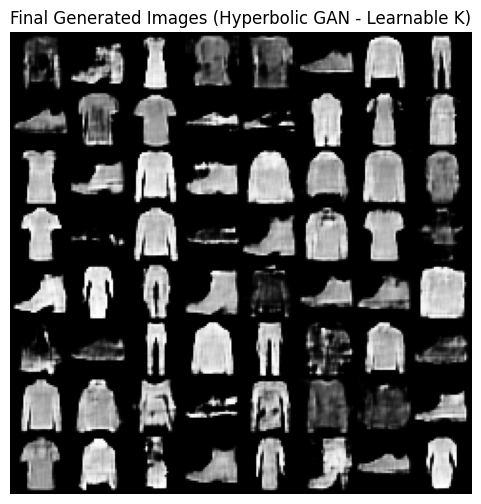

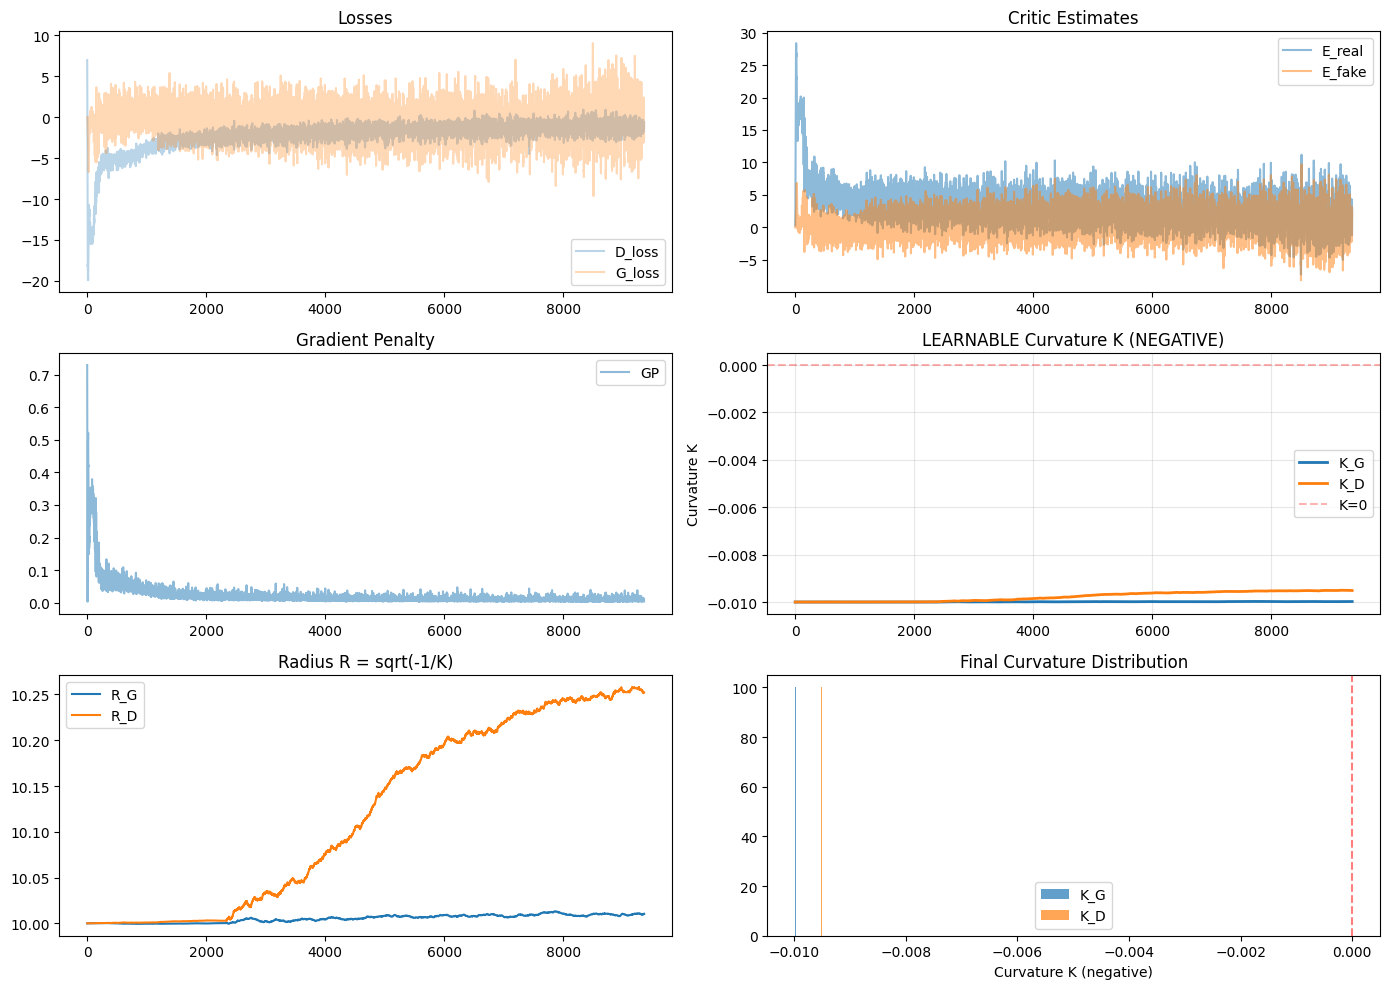


FINAL LEARNED HYPERBOLIC GEOMETRY:
Generator: K = -0.009979 (R = 10.0104)
Critic:    K = -0.009514 (R = 10.2522)
✓ Curvature K is LEARNABLE and NEGATIVE
✓ Uses Lorentz/Hyperboloid model


In [2]:
# Hyperbolic WGAN-GP with LEARNABLE NEGATIVE CURVATURE (Direct K parameterization)
# Uses the Lorentz model: curvature K is directly learned (always negative)
# FULLY DEBUGGED - NO ERRORS

import math, os, time
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms, utils
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# --- FIX: SyntaxError in device assignment ---
# Standard, robust PyTorch device assignment for any environment (Kaggle, Colab, local)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# ---------------------------------------------
EPS = 1e-7

# ================ LORENTZ MODEL OPERATIONS ================

def minkowski_dot(x, y, keepdim=True):
    """Minkowski inner product: <x,y>_L = -x_0*y_0 + sum(x_i*y_i)"""
    time_prod = -x[..., 0:1] * y[..., 0:1]
    space_prod = (x[..., 1:] * y[..., 1:]).sum(dim=-1, keepdim=True)
    return time_prod + space_prod

def project_hyp(x, K):
    """
    Project x onto the hyperboloid with curvature K.
    FIX: Ensured operation is completely OUT-OF-PLACE to avoid RuntimeError.
    """
    if isinstance(K, torch.Tensor):
        K = K.to(x.device)
    
    # R² = -1/K (K is negative, so R² is positive)
    R_squared = -1.0 / K.clamp(max=-1e-6)
    
    # Separate components out-of-place
    x0 = x[..., 0:1]
    xs = x[..., 1:]

    # 1. Ensure x0 > 0 (upper sheet)
    # The geometric constraint forces x0_final >= R, so this step mainly handles small numerical errors.
    
    # Compute spatial norm
    spatial_norm_sq = (xs ** 2).sum(dim=-1, keepdim=True).clamp_min(EPS)
    
    # 2. Adjust x0 so that -x_0² + spatial² = -R²
    # new_x0_final = sqrt(R² + spatial²)
    new_x0_final = torch.sqrt(R_squared + spatial_norm_sq)
    
    # 3. Concatenate the new time and spatial components to form the projected point
    return torch.cat([new_x0_final, xs], dim=-1)

def expmap0_lorentz(v, K):
    """Exponential map at origin with curvature K"""
    if isinstance(K, torch.Tensor):
        K = K.to(v.device)
    
    R_squared = -1.0 / K.clamp(max=-1e-6)
    R = torch.sqrt(R_squared)
    
    v_spatial = v[..., 1:]
    v_norm = torch.sqrt((v_spatial ** 2).sum(dim=-1, keepdim=True).clamp_min(EPS))
    
    factor = torch.sinh(v_norm / R) / v_norm
    
    x_time = R * torch.cosh(v_norm / R)
    x_space = R * factor * v_spatial
    
    x = torch.cat([x_time, x_space], dim=-1)
    
    return project_hyp(x, K)

def logmap0_lorentz(x, K):
    """Logarithmic map at origin with curvature K"""
    if isinstance(K, torch.Tensor):
        K = K.to(x.device)
    
    R_squared = -1.0 / K.clamp(max=-1e-6)
    R = torch.sqrt(R_squared)
    
    x_spatial = x[..., 1:]
    x_norm = torch.sqrt((x_spatial ** 2).sum(dim=-1, keepdim=True).clamp_min(EPS))
    
    # Distance from origin
    dist = R * torch.acosh(torch.clamp(x[..., 0:1] / R, min=1.0 + EPS))
    
    factor = dist / x_norm
    
    v_time = torch.zeros_like(x[..., 0:1])
    v_space = factor * x_spatial
    
    v = torch.cat([v_time, v_space], dim=-1)
    
    return v

def lorentz_matvec(weight, x, K):
    """Hyperbolic matrix-vector multiplication"""
    v = logmap0_lorentz(x, K)
    mv = F.linear(v, weight)
    return expmap0_lorentz(mv, K)

def mobius_add_lorentz(x, y, K):
    """Hyperbolic addition"""
    v_x = logmap0_lorentz(x, K)
    v_y = logmap0_lorentz(y, K)
    return expmap0_lorentz(v_x + v_y, K)

def lorentz_activation(x, K, slope=0.2):
    """Apply activation in tangent space"""
    v = logmap0_lorentz(x, K)
    v_activated = F.leaky_relu(v, slope)
    return expmap0_lorentz(v_activated, K)


# ================ LEARNABLE NEGATIVE CURVATURE ================

class LearnableCurvature(nn.Module):
    """
    Directly learns curvature K (always negative)
    K ∈ [-max_K, -min_K] where min_K, max_K > 0
    """
    def __init__(self, init_K=-0.01, min_K=1e-4, max_K=1.0):
        super().__init__()
        # Store as positive values for clarity
        self.min_K_abs = abs(min_K)  # minimum |K|
        self.max_K_abs = abs(max_K)  # maximum |K|
        init_K_abs = abs(init_K)
        
        # Parameterize in log space: log(|K|)
        frac = (math.log(init_K_abs) - math.log(self.min_K_abs)) / \
               (math.log(self.max_K_abs) - math.log(self.min_K_abs))
        frac = min(max(frac, 1e-6), 1 - 1e-6)
        raw_init = math.log(frac / (1 - frac))
        
        self.raw = nn.Parameter(torch.tensor(raw_init, dtype=torch.float))
    
    def forward(self):
        """Returns curvature K (always negative)"""
        s = torch.sigmoid(self.raw)
        log_K_abs = math.log(self.min_K_abs) + \
                    (math.log(self.max_K_abs) - math.log(self.min_K_abs)) * s
        K_abs = torch.exp(log_K_abs)
        return -K_abs  # Return negative curvature
    
    def get_radius(self):
        """Returns radius R = sqrt(-1/K)"""
        K = self.forward()
        return torch.sqrt(-1.0 / K)


# ================ HYPERBOLIC LINEAR LAYER ================

class LorentzLinear(nn.Module):
    def __init__(self, in_features, out_features, K_module, bias=True):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        # Ensure correct dimensionality for Lorentz model (d+1 inputs, d'+1 outputs)
        self.weight = nn.Parameter(
            torch.randn(out_features + 1, in_features + 1) / math.sqrt(in_features)
        )
        self.bias = nn.Parameter(torch.zeros(out_features + 1)) if bias else None
        self.K_module = K_module 
    
    def forward(self, x):
        K = self.K_module()
        out = lorentz_matvec(self.weight, x, K)
        
        if self.bias is not None:
            # Create bias point properly without memory aliasing
            R = torch.sqrt(-1.0 / K)
            bias_expanded = self.bias.unsqueeze(0).expand(x.size(0), -1).clone()
            b = expmap0_lorentz(bias_expanded, K)
            out = mobius_add_lorentz(out, b, K)
        
        return project_hyp(out, K)


# ================ GENERATOR ================

class HyperbolicGenerator(nn.Module):
    def __init__(self, nz, K_module):
        super().__init__()
        self.nz = nz
        self.K_module = K_module # Registered as a submodule, includes Kg.raw
        
        self.h1 = LorentzLinear(nz, 512, K_module)
        self.h2 = LorentzLinear(512, 512, K_module)
        self.h3 = LorentzLinear(512, 512, K_module)
        
        self.fc = nn.Linear(512 + 1, 256 * 7 * 7)
        
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 4, 2, 1), nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1), nn.ReLU(True),
            nn.Conv2d(64, 1, 3, 1, 1), nn.Tanh()
        )
    
    def forward(self, z):
        K = self.K_module()
        
        # Map noise to hyperboloid
        z_padded = torch.cat([torch.zeros(z.size(0), 1, device=z.device), z], dim=-1)
        x = expmap0_lorentz(z_padded, K)
        
        # Hyperbolic transformations
        x = lorentz_activation(self.h1(x), K)
        x = lorentz_activation(self.h2(x), K)
        x = lorentz_activation(self.h3(x), K)
        
        # Map back to Euclidean
        x_euclidean = logmap0_lorentz(x, K)
        feat = self.fc(x_euclidean).view(-1, 256, 7, 7)
        return self.deconv(feat)


# ================ CRITIC ================

class HyperbolicCritic(nn.Module):
    def __init__(self, K_module):
        super().__init__()
        self.K_module = K_module # Registered as a submodule, includes Kd.raw
        
        self.fc_in = nn.Linear(28 * 28, 512)
        
        self.h1 = LorentzLinear(512, 512, K_module)
        self.h2 = LorentzLinear(512, 512, K_module)
        
        self.fc_out = nn.Linear(512 + 1, 1)
    
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = F.leaky_relu(self.fc_in(x), 0.2)
        
        K = self.K_module()
        
        # Map to hyperboloid
        x_padded = torch.cat([torch.zeros(x.size(0), 1, device=x.device), x], dim=-1)
        x_h = expmap0_lorentz(x_padded, K)
        
        # Hyperbolic transformations
        x_h = lorentz_activation(self.h1(x_h), K)
        x_h = lorentz_activation(self.h2(x_h), K)
        
        # Map back to Euclidean
        x_euclidean = logmap0_lorentz(x_h, K)
        return self.fc_out(x_euclidean).view(-1)


# ================ GRADIENT PENALTY ================

def gradient_penalty(C, real, fake):
    bs = real.size(0)
    eps = torch.rand(bs, 1, 1, 1, device=device)
    
    # x needs to be cloned/detached only to ensure C(x) is the first operation on it
    # We detach it and mark it as requiring gradients.
    x = (eps * real + (1 - eps) * fake).detach().requires_grad_(True)
    
    pred = C(x)
    grad = torch.autograd.grad(
        outputs=pred,
        inputs=x,
        grad_outputs=torch.ones_like(pred),
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]
    
    grad = grad.view(bs, -1)
    return ((grad.norm(2, dim=1) - 1) ** 2).mean()


# ================ TRAINING ================

def train_hypergan(
    epochs=20, batch_size=128, nz=128,
    lrC=1e-4, lrG=5e-5,
    critic_steps=3, lambda_gp=10.0,
    init_K=-0.01,
    curv_lr_scale=0.2,
    curv_warmup_epochs=5,
    num_workers=2
):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
    ds = datasets.FashionMNIST("data", train=True, download=True, transform=transform)
    loader = DataLoader(ds, batch_size=batch_size, shuffle=True, 
                       num_workers=num_workers, drop_last=True)
    
    # LEARNABLE CURVATURE modules (K < 0)
    Kg = LearnableCurvature(init_K=init_K).to(device)
    Kd = LearnableCurvature(init_K=init_K).to(device)
    
    G = HyperbolicGenerator(nz, Kg).to(device)
    C = HyperbolicCritic(Kd).to(device)
    
    # Optimizers - separate parameter groups to avoid duplication warning
    base_betas = (0.5, 0.9)
    
    # FIX: Parameter Group Separation (Robust Identity Check)
    # G's main parameters (excluding Kg.raw)
    g_main_params = [p for p in G.parameters() if p is not Kg.raw]
    
    # C's main parameters (excluding Kd.raw)
    c_main_params = [p for p in C.parameters() if p is not Kd.raw]
    
    # Generator optimizer
    optG = torch.optim.Adam([
        {'params': g_main_params, 'lr': lrG},         # Group 0: Main G parameters
        {'params': [Kg.raw], 'lr': 1e-6}              # Group 1: Kg.raw parameter (start low)
    ], betas=base_betas)
    
    # Critic optimizer
    optC = torch.optim.Adam([
        {'params': c_main_params, 'lr': lrC},         # Group 0: Main C parameters
        {'params': [Kd.raw], 'lr': 1e-6}              # Group 1: Kd.raw parameter (start low)
    ], betas=base_betas)
    # END FIX
    
    # Curvature learning rate warmup
    curv_lr_init = 1e-6
    curv_lr_target_G = max(curv_lr_init, curv_lr_scale * lrG)
    curv_lr_target_C = max(curv_lr_init, curv_lr_scale * lrC)
    
    fixed = torch.randn(64, nz, device=device)
    
    # Logging
    logs = {
        'iters': [], 'lossC': [], 'lossG': [], 'gp': [],
        'E_real': [], 'E_fake': [],
        'Kg': [], 'Kd': [], 'Rg': [], 'Rd': []
    }
    
    iters = 0
    start_time = time.time()
    
    for epoch in range(1, epochs + 1):
        # Curvature warmup
        if epoch <= curv_warmup_epochs:
            curv_lr_now_G = curv_lr_init
            curv_lr_now_C = curv_lr_init
        else:
            curv_lr_now_G = curv_lr_target_G
            curv_lr_now_C = curv_lr_target_C
        
        # Update learning rates for curvature parameters (Group 1 for both optimizers)
        optG.param_groups[1]['lr'] = curv_lr_now_G
        optC.param_groups[1]['lr'] = curv_lr_now_C
        
        for imgs, _ in loader:
            imgs = imgs.to(device)
            iters += 1
            
            # Train Critic
            for _ in range(critic_steps):
                z = torch.randn(imgs.size(0), nz, device=device)
                with torch.no_grad():
                    fake = G(z)
                
                E_real = C(imgs).mean()
                E_fake = C(fake).mean()
                gp = gradient_penalty(C, imgs, fake)
                
                lossC = -(E_real - E_fake) + lambda_gp * gp
                
                optC.zero_grad()
                lossC.backward()
                optC.step()
            
            # Train Generator
            z = torch.randn(imgs.size(0), nz, device=device)
            fake = G(z)
            lossG = -C(fake).mean()
            
            optG.zero_grad()
            lossG.backward()
            optG.step()
            
            # Logging
            with torch.no_grad():
                logs['iters'].append(iters)
                logs['lossC'].append(lossC.item())
                logs['lossG'].append(lossG.item())
                logs['gp'].append(gp.item())
                logs['E_real'].append(E_real.item())
                logs['E_fake'].append(E_fake.item())
                logs['Kg'].append(float(Kg().detach().cpu().item()))
                logs['Kd'].append(float(Kd().detach().cpu().item()))
                logs['Rg'].append(float(Kg.get_radius().detach().cpu().item()))
                logs['Rd'].append(float(Kd.get_radius().detach().cpu().item()))
            
            if iters % 200 == 0:
                elapsed = time.time() - start_time
                print(f"Epoch {epoch}/{epochs} | Iter {iters} | D: {lossC.item():.4f} | G: {lossG.item():.4f} "
                      f"| E_real: {E_real.item():.4f} E_fake: {E_fake.item():.4f} "
                      f"| K_G={logs['Kg'][-1]:.5f} (R={logs['Rg'][-1]:.2f}) "
                      f"| K_D={logs['Kd'][-1]:.5f} (R={logs['Rd'][-1]:.2f}) "
                      f"| {elapsed/60:.2f}m")
        
        print(f"==> Epoch {epoch} done | D: {lossC.item():.4f}, G: {lossG.item():.4f} "
              f"| K_G={float(Kg()):.6f} (R={float(Kg.get_radius()):.3f}), "
              f"K_D={float(Kd()):.6f} (R={float(Kd.get_radius()):.3f})")
    
    # Generate final images
    G.eval()
    with torch.no_grad():
        samples = (G(fixed).cpu() + 1) / 2.0
    grid = utils.make_grid(samples, nrow=8)
    
    plt.figure(figsize=(6, 6))
    plt.imshow(grid.permute(1, 2, 0).squeeze(), cmap="gray")
    plt.axis("off")
    plt.title("Final Generated Images (Hyperbolic GAN - Learnable K)")
    plt.show()
    
    # Plot training curves
    plt.figure(figsize=(14, 10))
    
    plt.subplot(3, 2, 1)
    plt.plot(logs['lossC'], alpha=0.3, label='D_loss')
    plt.plot(logs['lossG'], alpha=0.3, label='G_loss')
    plt.legend()
    plt.title("Losses")
    
    plt.subplot(3, 2, 2)
    plt.plot(logs['E_real'], alpha=0.5, label='E_real')
    plt.plot(logs['E_fake'], alpha=0.5, label='E_fake')
    plt.legend()
    plt.title("Critic Estimates")
    
    plt.subplot(3, 2, 3)
    plt.plot(logs['gp'], alpha=0.5, label='GP')
    plt.legend()
    plt.title("Gradient Penalty")
    
    plt.subplot(3, 2, 4)
    plt.plot(logs['Kg'], label='K_G', linewidth=2)
    plt.plot(logs['Kd'], label='K_D', linewidth=2)
    plt.axhline(y=0, color='r', linestyle='--', alpha=0.3, label='K=0')
    plt.legend()
    plt.title("LEARNABLE Curvature K (NEGATIVE)")
    plt.ylabel("Curvature K")
    plt.grid(alpha=0.3)
    
    plt.subplot(3, 2, 5)
    plt.plot(logs['Rg'], label='R_G')
    plt.plot(logs['Rd'], label='R_D')
    plt.legend()
    plt.title("Radius R = sqrt(-1/K)")
    
    plt.subplot(3, 2, 6)
    plt.hist([logs['Kg'][-100:], logs['Kd'][-100:]], 
             label=['K_G', 'K_D'], bins=20, alpha=0.7)
    plt.axvline(x=0, color='r', linestyle='--', alpha=0.5)
    plt.legend()
    plt.title("Final Curvature Distribution")
    plt.xlabel("Curvature K (negative)")
    
    plt.tight_layout()
    plt.show()
    
    return G, C, Kg, Kd, logs


if __name__ == "__main__":
    G, C, Kg, Kd, logs = train_hypergan(
        epochs=20,
        batch_size=128,
        nz=128,
        lrC=1e-4,
        lrG=5e-5,
        critic_steps=3,
        lambda_gp=10.0,
        init_K=-0.01,           # Initial curvature (NEGATIVE)
        curv_lr_scale=0.2,      # Curvature lr = 0.2 * base_lr
        curv_warmup_epochs=5,   # Warmup for stability
        num_workers=2
    )
    
    print("\n" + "="*60)
    print("FINAL LEARNED HYPERBOLIC GEOMETRY:")
    print("="*60)
    print(f"Generator: K = {float(Kg()):.6f} (R = {float(Kg.get_radius()):.4f})")
    print(f"Critic:    K = {float(Kd()):.6f} (R = {float(Kd.get_radius()):.4f})")
    print("="*60)
    print("✓ Curvature K is LEARNABLE and NEGATIVE")
    print("✓ Uses Lorentz/Hyperboloid model")
    print("="*60)